<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em></center>

# MNIST mit Multi-Layer Perceptron

In dieser Lektion werden wir ein Multi Layer Perceptron Modell erstellen und versuchen damit handgeschriebenen Zahlen zu klassifizieren. Das ist ein sehr verbreitetes Einsteigerproblem für Tensorflow.

Denkt daran, dass eine einzige Lektion niemals ausreichen wird, um Deep Learning und/oder Tensorflow in seiner Komlexität abzudecken!

## Die Daten laden

Wir werden die berühmten MNIST Daten über [handgeschriebenen Zahlen](http://yann.lecun.com/exdb/mnist/) verwenden.

Die Bilder die wir verwenden werden sind schwarz-weiß Bilder der größe 28 x 28, d.h. 784 Pixel insgesamt. Unsere Features werden die Pixelwerte für jeden Pixel sein. Entweder ist der Pixel "weiß" (also eine 0 in den Daten) oder er hat einen Pixelwert.

Wir werden versuchen korrekt vorherzusagen, welche Nummer geschrieben steht. Dazu verwenden wir lediglich die Bilddaten in Form unseres Arrays. Diese Art von Problem (Image Recognition oder auf Deutsch: Bilderkennung) ist ein tolle Use Case für Deep Learning Methoden!

Die Daten sind für Deep Learning das, was der Iris Datensatz für typische Machine Learning Algorithmen ist.

# Installieren der Bibliothek Zipfile für die spätere Verwendung.

In diesem Code wird die Python-Bibliotheken Zipfile installiert.

In [1]:
pip install zipfile

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


# Import von Bibliotheken in Python.

In diesem Code werden die Python-Bibliotheken TensorFlow, NumPy, Logging, Time, Matplotlib und Unittest importiert.

In [2]:
import tensorflow as tf
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import struct
import unittest
import psutil
import zipfile

# Zusammensetzen der Train-Images des MNIST Datensatzes.

In diesem Codeabschnitt wird der Trainings-Datensatz des MNIST-Datensatz zusammengebaut. Aufgrund des Dateigrößen Limits von GitHUb (25MB) wurde die Trainingsdatensatz-Datei (45MB) zuvor in drei Zip-Files gepackt welche im nächsten Abschnitt entpackt werden und die original Trainingsdaten wieder zur Verfügung stellt. Anschließend wird das System für 15Sekunden pausierst, um die vollständige Wiederherstellung des Trainingsdatensatzes zu gewährleisten.

In [3]:
# Anzahl der Teildateien
num_parts = 3

# Wiederherstellen der ursprünglichen Datei
output_file = "train-images.idx3-ubyte"
with open(output_file, 'wb') as restored_file:
    for i in range(num_parts):
        part_file = f"part_{i+1}.zip"
        with zipfile.ZipFile(part_file, 'r') as part_zip:
            data = part_zip.read("data")
            restored_file.write(data)

In [4]:
# Warte 15 Sekunden, bevor der nächste Codeabschnitt ausgeführt wird
time.sleep(15)

# Datenverarbeitung des MNIST Datensatzes.

Dieser Codeabschnitt importiert verschiedene Python-Bibliotheken, verarbeitet den den MNIST-Datensatz welcher bereits heruntergeladen wurde und in dem Repositorie mit abgelegt ist. Zusätzlich werden die Daten normalisiert, teilt die Daten in Trainings- und Testdaten auf und konvertiert die Trainingsdaten in das gewünschte Datenformat für die spätere Verwendung.

In [5]:
from functools import wraps
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Pfad zu den heruntergeladenen MNIST-Daten
train_data_path = 'train-images.idx3-ubyte'
test_data_path = 't10k-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'  # Hinzugefügt
test_labels_path = 't10k-labels.idx1-ubyte'  # Hinzugefügt

# Laden der MNIST-Daten aus den lokal gespeicherten Dateien
def load_mnist_data(data_path):
    with open(data_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
    return images

# Laden der MNIST-Label aus den lokal gespeicherten Dateien (Hinzugefügt)
def load_mnist_labels(labels_path):
    with open(labels_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Laden Sie die MNIST-Trainings- und Testdaten
x_train_mnist = load_mnist_data(train_data_path)
x_test_mnist = load_mnist_data(test_data_path)
# Laden Sie die MNIST-Label
train_labels = load_mnist_labels(train_labels_path)
test_labels = load_mnist_labels(test_labels_path)

# Normalisieren der Daten
class Normalize(object):
    def normalize(self, X_train, X_test):
        self.scaler = MinMaxScaler()
        # Umformen in 2D-Arrays (Flatten)
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return (X_train, X_test)

    def inverse(self, X_train, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_test = self.scaler.inverse_transform(X_test)
        return (X_train, X_test)

# Aufteilen der Daten
def split(X, y, splitRatio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    return (X_train, y_train, X_test, y_test)

# Annahme: Sie haben bereits die MNIST-Trainings- und Testdaten geladen und in x_train_mnist und x_test_mnist gespeichert.

# Normalisieren der Daten
normalizer = Normalize()
x_train, x_test = normalizer.normalize(x_train_mnist, x_test_mnist)

# Aufteilen der Daten
splitRatio = 0.8  # Ändern Sie den Split-Verhältnis nach Bedarf
x_train, y_train, x_test, y_test = split(x_train, train_labels, splitRatio)

# Stellen Sie sicher, dass die Daten korrekt geladen wurden (ersetzen Sie y durch die entsprechenden Label-Daten)
assert x_train.shape == (int(0.8 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert x_test.shape == (int(0.2 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert y_train.shape == (int(0.8 * len(x_train_mnist)),)
assert y_test.shape == (int(0.2 * len(x_train_mnist)),)

## Definieren der my_logger und my_timer Funktion

In [6]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

In [7]:
def my_timer(orig_func):
    import time

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

In diesem Code wird eine Python-Klasse mit dem Namen "TheAlgorithm" definiert, die verschiedene Methoden wie den Konstruktor __init__, die Methode fit und die Methode predict enthält, wobei die Dekoratoren @my_logger und @my_timer verwendet werden, um die Ausführung dieser Methoden zu protokollieren und die Zeitmessung durchzuführen.

In [8]:
class TheAlgorithm(object):
    @my_logger
    @my_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @my_logger
    @my_timer
    def fit(self):
        x_train, y_train, x_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test

        normalizer = Normalize()  # Use the correct class name here
        x_train, x_test = normalizer.normalize(x_train, x_test)

        train_samples = x_train.shape[0]

        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight='balanced',
        )

        self.classifier.fit(x_train, y_train)
        self.train_predictions = self.classifier.predict(x_train)
        self.train_accuracy = np.mean(self.train_predictions.ravel() == y_train.ravel()) * 100
        self.train_confusion_matrix = confusion_matrix(y_train, self.train_predictions)
        return self.train_accuracy

    @my_logger
    @my_timer
    def predict(self):
        x_test = self.X_test  # Test data doesn't need to be normalized again

        self.test_predictions = self.classifier.predict(x_test)
        self.test_accuracy = np.mean(self.test_predictions.ravel() == self.y_test.ravel()) * 100
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_predictions)
        self.report = classification_report(self.y_test, self.test_predictions)
        print("Classification Report for the classifier:\n%s\n" % (self.report))

        return self.test_accuracy


## Daten Format

Die Daten sind im Vektor Format gespeichert, obwohl die Originaldaten eine 2-dimensionale Matrix waren, die angab, wie viele Pigmente sich an welcher Position befinden. Untersuchen wir das genauer:

In [9]:
type(mnist)

module

In [10]:
type(x_train)
type(y_train)

numpy.ndarray

In [11]:
x_train[2].shape

(784,)

In [12]:
sample = x_train[2].reshape(28, 28)

In [13]:
%matplotlib inline

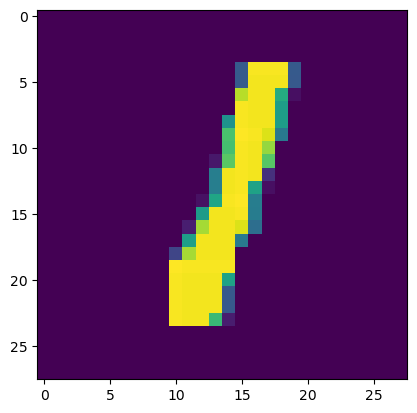

In [14]:
plt.imshow(sample)

## Parameter

Wir werden 4 Parameter definieren müssen. Es ist wirklich (wirklich) schwer gute Parameterwerte für einen Datensatz zu bestimmen, mit dem man keine Erfahrung hat. Da dieser MNIST Datensatz allerdings so berühmt ist haben wir schon einige Ausgangswerte. Die Parameter sind:

* Learning Rate - Wie schnell die Kostenfunktion angepasst wird
* Traing Epochs - Wie viele Trainingszyklen durchlaufen werden sollen
* Batch Size - Größe der "Batches" an Traingsdaten

In [15]:
# Parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### Netzwerk Parameter

Hier haben wir Parameter welche unser Neuronales Netz direkt definieren. Diese werden entsprechend der betrachteten Daten angepasst und hängen auch davon ab, welche Art von Netz man nutzt. Es sind bis zu diesem Punkt erst einmal nur Zahlen, die wir später verwenden, um unser Netz zu definieren:

In [16]:
# Netzwerk Parameter
n_hidden_1 = 256  # 1. Layer: Anzahl an Features
n_hidden_2 = 256  # 2. Layer: Anzahl an Features
n_input = 784     # MNIST Daten Input (img shape: 28*28)
n_classes = 10    # MNIST Klassen (0-9 Zahlen)
n_samples = len(x_train)  # Anzahl der Trainingsbeispiele

### Tensorflow Graph Input

In [17]:
x = tf.keras.Input(shape=(n_input,), dtype=tf.float32)
y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32)

## MultiLayer Modell

Es ist Zeit unser Modell zu erstellen. Wiederholen wir deshalb kurz, was wir erstellen wollen:

Zuerst erhalten wir einen *Input* in Form eines Datenarrays und schicken diesen an die erste *Hidden Layer*. Dann wird den Daten ein  *Weight* zwischen den Schichten zugewiesen (welches zuerst ein zufälliger Wert ist). Anschließend wird es an einen *Node* geschicht und unterläuft eine *Activation Function* (zusammen mit einem Bias, wie in der Neural Network Lektion erwähnt). Dann geht es weiter zur nächsten *Layer* und immer so weiter, bis zur finalen *Output Layer*. In unserem Fall werden wir nur 2 *Hidden Layers* verwenden. Je mehr wir davon verwenden, desto länger braucht das Modell (aber er hat mehr Möglichkeiten um die Genauigkeit zu erhöhen).

Sobald die transformierte Daten die *Output Layer* erreicht haben müssen wir sie auswerten. Hier verwenden wir eine *Loss Function* (auch Cost Function genannt). Diese berechnet, wie sehr wir vom gewünschten Ergebnis entfernt sind. In diesem Fall: Wie viele der Klassen wir richtig zugeteilt haben.

Dann wenden wir eine Optimierungsfunktion an, um die *Costs* (bzw. den Error) zu minimieren. Dies geschiet durch die Anpassung der *Weights* entlang des Netzes. Wir verwenden in unserem Beispiel den [Adam Optimizer](https://arxiv.org/pdf/1412.6980v8.pdf), welcher eine (im Vergleich zu anderen) sehr neue Entwicklung ist.

Wir können anpassen, wie schnell diese Optimierung angewendet wird, indem wir unseren *Learning Rate* Parameter anpassen. Je geringer die Rate, desto höher die Möglichkeiten für Anpassungen. Dies erzeugt allerdings die Kosten einer erhöhten Wartezeit. Ab einem bestimmten Punkt lohnt es sich nicht mehr, die Learning Rate weiter zu senken.

Jetzt können wir unser Modell erstellen. Wir beginnen mit 2 Hidden Layers, welche die []() Activation Function verwenden. Dies ist eine einfache Umformungsfunktion, die entweder x oder 0 zurückgibt. Für unsere finale Output Layer verwenden wir eine lineare Activation mit Matrixmultiplikation:

In diesem Code wird eine Funktion namens "multilayer_perceptron" definiert, die ein mehrschichtiges neuronales Netzwerk mit ReLU-Aktivierungsfunktionen für die Hidden Layers und linearer Aktivierungsfunktion für die Output Layer erstellt und die Ausgabe des Netzwerks zurückgibt, wobei die Funktionen `my_logger` und `my_timer` als Dekoratoren verwendet werden, um die Ausführung der Funktion zu protokollieren und die Zeitmessung durchzuführen.

In [18]:
@my_logger
@my_timer
def multilayer_perceptron(x, weights, biases):
    
    # Erste Hidden layer mit RELU Activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Zweite Hidden layer mit RELU Activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Letzte Output layer mit linearer Activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

## Weights und Bias

Damit unser Tensorflow Modell funktioniert müssen wir zwei Dictionaries anlegen, die unsere Weights und Biases enthalten. Wir können das `tf.variable` Objekt verwenden. Dies ist anders als eine Konstante, da Tensorflow's Graph Objekt alle Zustände der Variablen wahrnimmt. Eine Variable ist ein anpassbares Tensor, der zwischen Tensorflow's Graph von interagierenden Operationen lebt. Er kann durch die Berechnung verwendet und verändert werden. Wir werden die Modell Parameter generell als Variablen verwenden. Aus der Dokumentation können wir entnehmen:

    A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.

    The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
Wir werden Tensorflow's eingebaute `random_normal` Methode verwenden, um zufällige Werte für unsere Weights und Biases zu erstellen.

In [19]:
# Gewichtsinitialisierung
weights = {
    'h1': tf.Variable(tf.initializers.RandomNormal()(shape=[n_input, n_hidden_1])),
    'h2': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_2, n_classes]))
}

In [20]:
# Bias-Initialisierung
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

In [21]:
# Model erstellen
pred = multilayer_perceptron(x, weights, biases)

multilayer_perceptron ran in: 0.03377962112426758 sec


## Cost und Optimierungs-Funktion

Wir verwenden Tensorflow's eingebaute Funktionen für diesesn Teil. Weitere Details bietet die Dokumentation:

In [22]:
# Cost und Optimierungsfunktion definieren
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits=pred))

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### Initialisierung der Variablen

Wir initialisieren nun alle tf.Variable Objekte die wir zuvor erstellt haben. Das wird das erste sein, dass wir ausführen, wenn wir unser Modell trainieren.

## Das Modell trainieren

### next_batch()

Bevor wir beginnen möchte ich eine weitere nützliche Funktion in unserem MNIST Datenobjekt abdecken, die `next_batch` heißt. Diese gibt ein Tupel in der Form (X,y) mit einem X Array der Daten und einem y Array der Klasse. Zum Beispiel:

In [24]:
# Erstelle ein TensorFlow-Dataset aus den Trainingsdaten
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Mische die Daten und teile sie in Batches auf
batch_size = 1
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

# Erstelle einen Iterator für das Dataset
train_iterator = iter(train_dataset)

# Greife auf ein Batch von Daten zu
Xsamp, ysamp = next(train_iterator)

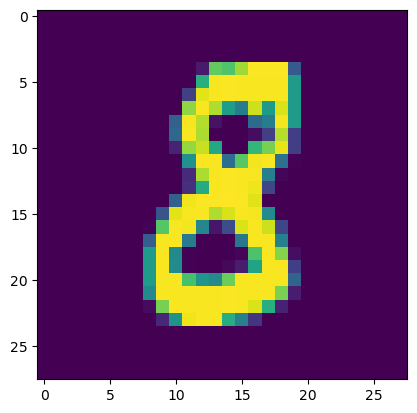

In [25]:
# Wandele Xsamp in ein Numpy-Array um
Xsamp_numpy = Xsamp.numpy()

# Zeige das Bild mit imshow
plt.imshow(Xsamp_numpy.reshape(28, 28))

In [26]:
print(ysamp)

tf.Tensor([8], shape=(1,), dtype=uint8)


In [27]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper
def my_timer(orig_func):

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

## Die Session ausführen

Jetzt ist es Zeit unsere Session auszuführen! Achte darauf wie wir zwei Schleifen verwenden. Die äußere, die die Epochs durchläuft, und die innere, die die Batches für jede Epoch des Trainings ausführt.

## Wichtig, hier wurden aus zeitlichen Gründen wurde mit 1% der Daten gearbeitet. Der Code ist mit Prozentzahl reproduzierbar.

Es wurde aus zeitlicher und übersichtlicher Sicht eine View sowie eine Abfrage des gewünschten Prozentsatzes eingebaut.

In [28]:
# from tensorflow import keras

# Eingabe vom Benutzer: Prozentsatz der Daten, die verarbeitet werden sollen
percentage_to_process = float(input("Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): "))

# Berechnen Sie die Anzahl der Datensätze, die verarbeitet werden sollen
n_samples_to_process = int(n_samples * (percentage_to_process / 100))

# Training Epochs
for epoch in range(training_epochs):
    avg_cost = 0.0

    total_batch = int(n_samples_to_process / batch_size)

    for i in range(total_batch):

        # Den nächsten Batch an Trainingsdaten und -labels nehmen

        batch_x = tf.cast(x_train[i * batch_size: (i + 1) * batch_size], tf.float32)
        batch_y = tf.cast(y_train[i * batch_size: (i + 1) * batch_size], tf.float32)

        # Führen Sie die Optimierung und Cost-Berechnung durch

        with tf.GradientTape() as tape:

            pred = multilayer_perceptron(batch_x, weights, biases)

            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=batch_y, logits=pred))

        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))

        avg_cost += loss / total_batch

    print("Epoch: {} Cost={:.4f}".format(epoch + 1, avg_cost))

print("Modellierung ist beendet: {} Epochs of Training".format(training_epochs))

Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): 1
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
mul

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015661001205444336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.015625953674316406 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624761581420898 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015610218048095703 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635967254638672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015613

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015634536743164062 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015651226043701172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015611886978149414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_p

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015648365020751953 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156400203704834 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percept

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015654563903808594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006526470184326172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612602233886719 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015628576278686523 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563119888305664 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 4 Cost=23926.2773
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563739776611328 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 s

multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.001987457275390625 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009992122650146484 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0019998550415039062 

multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0019829273223876953 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009980201721191406 sec
multilayer_perceptron ran in: 0.0010151863098144531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001016855239868164 sec
multilayer_perceptron ran in: 0.0020046234130859375 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009877681732177734 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.00099945068359375 

multilayer_perceptron ran in: 0.0020024776458740234 sec
multilayer_perceptron ran in: 0.0009984970092773438 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0019872188568115234 sec
multilayer_perceptron ran in: 0.0019867420196533203 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0019996166229248047 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.001001596450805664

multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010035037994384766 sec
multilayer_perceptron ran in: 0.0009987354278564453 sec
multilayer_perceptron ran in: 0.0019998550415039062 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001001119613647461 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.001000404357910156

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009982585906982422 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010175704956054688 sec
multilayer_perceptron ran in: 0.001996755599975586 sec
multilayer_perceptron ran in: 0.00099945068359375 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009965896606445312 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009992122650146484

multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0020003318786621094 sec
multilayer_perceptron ran in: 0.0009996891021728516 sec
multilayer_perceptron ran in: 0.002000093460083008 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0009908676147460938 sec
multilayer_perceptron ran in: 0.002000570297241211 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.000980377197265625 sec
multilayer_perceptron ran in: 0.0010008811950683594 sec
multilayer_perceptron ran in: 0.0010018348693847656 sec
multilayer_perceptron ran in: 0.002001523971557617 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0009999275207519531 sec
multilayer_perceptron ran in: 0.0010006427764892578 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
multilayer_perceptron ran in: 0.0010006427764892578 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.011002540588378906 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009000778198242188 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009006500244140625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.008986473083496094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00899815559387207 sec
multilayer_perceptron

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009003639221191406 sec
multilayer_perceptron ran in: 0.008986473083496094 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009016275405883789 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009000539779663086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00898885726928711 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percep

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009002208709716797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009000062942504883 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.009001016616821289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009001016616821289 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.009001731872558594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00900

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006521940231323242 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006524801254272461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638351440429688 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.015640735626220703 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015607595443725586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015602350234985352 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642404556274414 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 11 Cost=128477.0781
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron r

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.002017974853515625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015646934509277344 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
m

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624523162841797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563715934753418 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
mu

multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015636444091796875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015631437301635742 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec

multilayer_perceptron ran in: 0.015651941299438477 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015653610229492188 sec
multilayer_perceptron ran in: 0.01564478874206543 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0065267086029052734 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006522417068481445 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622138977050781 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 se

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156404972076416 sec
multilayer_perceptron ran in: 0.0010001659393310547 sec
multilayer_perceptron ran in: 0.01562047004699707 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564478874206543 sec
multil

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.01561117172241211 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percep

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627145767211914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

## Modell Auswertung

Tensorflow bietet einige eingebaute Funktionen, die uns bei der Auswertung helfen. Dazu gehören `tf.equal` und `tf.reduce_mean`.


### tf.equal

Dies ist im Grunde genommen nur eine Kontrolle, ob die Vorhersagen mit den Labels übereinstimmen. Da wir in unserem Fall wissen, dass die Labels eine 1 in einem Array von Nullen sind, können wir `argmax()` verwenden, um die Position zu vergleichen. Denke daran, dass y immer noch der Platzhalter ist, den wir anfangs erstellt haben. Wir werden eine Reihe an Operationen durchführen, um einen Tensor zu erhalten, in den wir die Testdaten einlesen können, um es auszuwerten.

In [29]:
# Teste das Modell
correct_predictions = tf.math.reduce_all(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)))

In [30]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.bool, name=None), name='tf.math.reduce_all/All:0', description="created by layer 'tf.math.reduce_all'")


Um numerische Werte für unsere Vorhersagen zu erhalten müssen wir `tf.cast` verwenden, um den Tensor mit Booleans zurückzuführen in einen Tensor mit Floats. Dann können wir den Durchschnitt nehmen.

In [31]:
correct_predictions = tf.cast(correct_predictions, "float")

In [32]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.cast/Cast:0', description="created by layer 'tf.cast'")


Jetzt können wir `tf.reduce_mean` verwenden, um den Durchschnitt der Elemente im Tensor zu erhalten:

In [33]:
accuracy = tf.reduce_mean(correct_predictions)

In [34]:
type(accuracy)

keras.engine.keras_tensor.KerasTensor

Das wirkt evtl. etwas merkwürdig, aber diese Genauigkeit ist immer noch ein Tensor Objekt. Denke daran, dass wir immer noch die tatsächlichen Testdaten übergeben müssen. Jetzt können wir die MNIST Testlabels und Bilder aufrufen und die Genauigkeit auswerten!

In [35]:
y_test

array([7, 3, 8, ..., 9, 7, 2], dtype=uint8)

In [36]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Dieser Code ist ein Python-Skript, das ein neuronales Netzwerk-Modell erstellt, kompiliert, trainiert und dann auf Testdaten auswertet. Ebenso wird später der Test_loss sowie die Test_Accurracy der einzelnen Epochen ausgegeben

In [37]:
# Erstellen des Modells
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_input,)),  
    tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=None)
])

# Kompilieren des Modells mit der Genauigkeitsmetrik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Trainieren des Modells auf den Trainingsdaten in Batches mit einer erhöhten Batch-Größe
x_train_flattened = x_train.reshape(-1, n_input)
batch_size = 128  # Erhöhen Sie die Batch-Größe, um die GPU besser auszulasten
model.fit(x_train_flattened, y_train, batch_size=batch_size, epochs=training_epochs)

# Evaluieren der Genauigkeit auf den Testdaten (nur am Ende)
x_test_flattened = x_test.reshape(-1, n_input)
test_loss, test_accuracy = model.evaluate(x_test_flattened, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
375/375 [==============================] - 2s 3ms/step - loss: 0.2989 - sparse_categorical_accuracy: 0.9152
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9664
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0716 - sparse_categorical_accuracy: 0.9784
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9835
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9881
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9901
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9924
Epoch 8/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9938
Epoch 9/15
375/375 [============================

# Initialisieren des Unittest

Dieser Codeabschnitt dient dazu, die Daten auf die Genauigkeit des Modells auf Trainings- und Testdaten zu bewerten. Es wird zusätzlich ein Classification Report ausgegeben. Die hier erzeugten Trainings- und Test-Accurracies werden im weiteren Code aufgegriffen und automatisiert getestet.

In [38]:
if __name__ == '__main__':
    X = x_train  # Hier die x_train-Matrix verwenden
    y = y_train  # Hier die y_train-Matrix verwenden
    print('MNIST:', X.shape, y.shape)
    
    # Überprüfe, ob X und y die gleiche Anzahl von Zeilen haben
    if X.shape[0] != y.shape[0]:
        raise ValueError("X und y haben unterschiedliche Anzahlen von Zeilen.")
    
    # Split und Modell initialisieren
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    np.random.seed(31337)
    ta = TheAlgorithm(X_train, y_train, X_test, y_test)
    
    # Modell trainieren
    train_accuracy = ta.fit()
    print('Train Accuracy:', train_accuracy)
    
    # Modellvorhersage auf Testdaten
    test_accuracy = ta.predict()
    print('Test Accuracy:', test_accuracy)

MNIST: (48000, 784) (48000,)
__init__ ran in: 0.0 sec
fit ran in: 12.105282306671143 sec
Train Accuracy: 72.53645833333333
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
           4       0.72      0.78      0.75       961
           5       0.62      0.44      0.51       844
           6       0.73      0.85      0.79       948
           7       0.75      0.79      0.77       978
           8       0.80      0.54      0.65       922
           9       0.77      0.59      0.67       940

    accuracy                           0.73      9600
   macro avg       0.73      0.72      0.72      9600
weighted avg       0.73      0.73      0.72      9600


predict ran in: 0.03777170181274414 sec
Test Accuracy: 73.19791666666666


# Durchführung der Unittests ausgeführt

Dies ist ein Unit-Test-Skript, das entwickelt wurde, um die Funktionalität und die Leistung eines Machine-Learning-Algorithmus zu testen. Ebenso wird getestet ob der Prozess in normalen Parametern läuft. In dem ersten Test wird ein Fehler der Laufzeit provoziert welches bei 0,01% der Zeit liegen darf. Im zweiten Test wird die Zeit auf 120% erhöht um zu zeigen dass das System die vorgegebe maximale Zeit einhält.

In [39]:
#Die Representative Laufzeit des Tests test_fit darf nicht länger als 0,01% der representativen Zeit sein

class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 0,01% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 0.0001 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.210926055908203 sec
setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.135381698608398 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
           4       0.72      0.78      0.75       961
           5       0.62      0.44      0.51       844
           6       0.73      0.85      0.79       948
           7       0.75      0.79      0.77       978
           8       0.80      0.54      0.65       922
           9       0.77      0.59      0.67       940

    accuracy                           0.73      9600
   macro avg       0.73      0.72      0.72      9600
weighted avg       0.73      0.73      0.72      9600


predict ran in: 0.046872854232788086 sec
setUp
__init__ ran in: 0.0 sec


F
FAIL: test_runtime_fit (__main__.TestInput.test_runtime_fit)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Phili\AppData\Local\Temp\ipykernel_16344\3699021566.py", line 58, in test_runtime_fit
    self.assertLessEqual(elapsed_time, max_allowed_runtime)
AssertionError: 12.286491870880127 not less than or equal to 0.0012286491870880127

----------------------------------------------------------------------
Ran 3 tests in 36.959s

FAILED (failures=1)


fit ran in: 12.286491870880127 sec


Test des Durchlaufs der Laufzeit von test_fit mit 120% der representativen Zeit

In [40]:
#Die Representative Laufzeit des Tests test_fit darf nicht länger als 120% der representativen Zeit sein

class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 1.2 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.225574016571045 sec
setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.476160526275635 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
           4       0.72      0.78      0.75       961
           5       0.62      0.44      0.51       844
           6       0.73      0.85      0.79       948
           7       0.75      0.79      0.77       978
           8       0.80      0.54      0.65       922
           9       0.77      0.59      0.67       940

    accuracy                           0.73      9600
   macro avg       0.73      0.72      0.72      9600
weighted avg       0.73      0.73      0.72      9600


predict ran in: 0.04687213897705078 sec
setUp
__init__ ran in: 0.0 sec


.
----------------------------------------------------------------------
Ran 3 tests in 37.538s

OK


fit ran in: 12.485648155212402 sec



# Gut gemacht!